In [1]:
from typing import List

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from data_service import get_index_daily, get_sales_depart_billboard
from matplotlib.ticker import MultipleLocator
from scr import HMA, get_forward_returns
from scr.plotting import plot_indicator, plot_quantile_group_ret
from scr.tushare_api import TuShare

my_ts = TuShare()

d:\anaconda3\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


# 数据准备

In [11]:
# 数据获取
billboard_df: pd.DataFrame = get_sales_depart_billboard(
    '2013-01-01', '2021-12-31')

# 数据储存
billboard_df.to_csv('../data/billboard.csv', encoding='utf-8')

机构龙虎榜数据获取:   0%|          | 0/2188 [00:00<?, ?it/s]

In [65]:
# 读取本地文件
billboard_df: pd.DataFrame = pd.read_csv('../data/billboard.csv',
                                         encoding='utf-8',
                                         index_col=[0],
                                         parse_dates=['trade_date'])

In [3]:
# 获取沪深300数据
hs300:pd.DataFrame = get_index_daily(code='000300.SH',start_date = '20130101',end_date='20220222')
hs300.set_index('trade_date',inplace=True)

In [14]:
# 查看数据结构
hs300.head()

,code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2013-01-04,000300.SH,2524.409,2551.814,2558.529,2498.892,2522.952,1.457,0.0577,97988182.0,9.557925e+07
2013-01-07,000300.SH,2535.985,2518.047,2545.969,2511.603,2524.409,11.576,0.4586,75167993.0,7.316751e+07
2013-01-08,000300.SH,2525.330,2534.647,2540.513,2502.490,2535.985,-10.655,-0.4202,71837100.0,7.649806e+07
2013-01-09,000300.SH,2526.126,2518.104,2534.239,2504.299,2525.330,0.796,0.0315,70231170.0,7.423360e+07
2013-01-10,000300.SH,2530.569,2525.590,2553.352,2513.729,2526.126,4.443,0.1759,71085862.0,7.115905e+07


In [15]:
# 查看数据结构
billboard_df.head()

,trade_date,code,exalter,buy,buy_rate,sell,sell_rate,net_buy,side,reason
0,2013-01-04,000043.SZ,中国国际金融有限公司上海淮海中路证券营业部,16970815.06,1.19,16377628.0,1.24,-593187.06,0,连续三个交易日内，涨幅偏离值累计达20%的证券
264,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,1,换手率达20%的证券
263,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,0,换手率达20%的证券
262,2013-01-04,300262.SZ,中国银河证券股份有限公司厦门美湖路证券营业部,7913689.96,0.01,26770.0,2.75,-7886919.96,1,换手率达20%的证券
261,2013-01-04,300262.SZ,中信证券股份有限公司上海淮海中路证券营业部,4772872.77,1.53,4398000.0,1.66,-374872.77,0,换手率达20%的证券


## 席位分析

In [158]:
# 营业部
cond1 = billboard_df['exalter'].str.contains('营业?|分公司',regex=True)
# 机构专用
cond2 = billboard_df['exalter'].str.contains('机构专用|机构投资者',regex=True)
# 交易单元
cond3 = billboard_df['exalter'].str.contains('交易单元')
# 深股通
cond4 = billboard_df['exalter'].str.contains('深股通专用|沪股通专用|深股通投资者',regex=True)
# 其他
cond5 = billboard_df['exalter'].str.contains('自然人|其他自然人|中小投资者|投资者分类',regex=True)

# 营业部总部
cond6 = (~cond1) & (~cond2) & (~cond3) & (~cond4) & (~cond5)

In [141]:
# 使用机构专用席位
filter_billboard = billboard_df[(cond2|cond3)]
filter_billboard.head()

,trade_date,code,exalter,buy,buy_rate,sell,sell_rate,net_buy,side,reason
259,2013-01-04,300251.SZ,机构专用,29139829.87,0.00,0.0,3.98,-29139829.87,1,换手率达20%的证券
258,2013-01-04,300251.SZ,机构专用,29483551.69,0.00,0.0,4.03,-29483551.69,1,换手率达20%的证券
257,2013-01-04,300251.SZ,机构专用,70062557.31,0.00,0.0,9.56,-70062557.31,1,换手率达20%的证券
288,2013-01-04,300295.SZ,机构专用,11092405.00,0.00,0.0,6.57,-11092405.00,1,涨幅偏离值达7%的证券
285,2013-01-04,300295.SZ,国泰君安交易单元(227002),0.00,5.27,8893500.0,0.00,8893500.00,0,涨幅偏离值达7%的证券


# 特征构建

In [142]:
# 计算当日所有单个席位净流入金额(单个席位买入 金额-单个席位卖出金额)的总和
nextbuy: pd.Series = filter_billboard.groupby('trade_date')['net_buy'].sum()

# IS_NetBuy/沪深 300 指数当日成交金额
is_netbuy_s: pd.Series = nextbuy / (hs300['amount'] * 1000)
is_netbuy_s: pd.Series = is_netbuy_s.dropna()

In [167]:
up_bound:pd.Series = is_netbuy_s.rolling(60).apply(lambda x:np.quantile(x,0.8))
low_bound:pd.Series = is_netbuy_s.rolling(60).apply(lambda x:np.quantile(x,0.15))

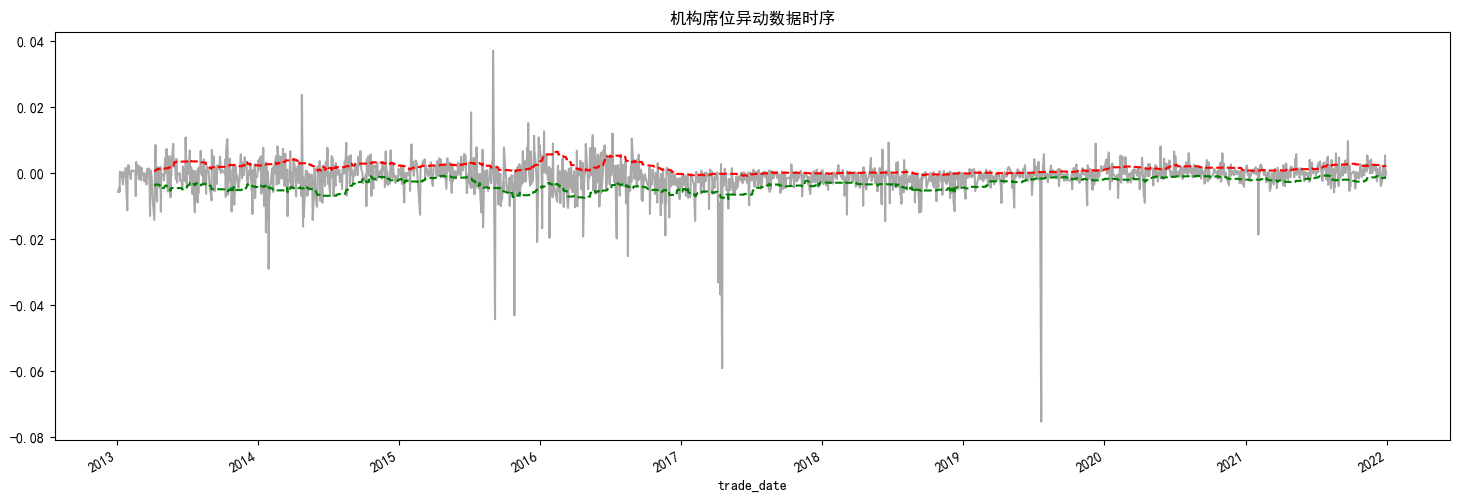

In [168]:
is_netbuy_s.plot(figsize=(18,6),color='darkgray',title='机构席位异动数据时序')
up_bound.plot(color='red',ls='--')
low_bound.plot(color='g',ls='--');

In [169]:
quantile_indincator:pd.DataFrame = pd.concat((up_bound,is_netbuy_s,low_bound),axis=1)
quantile_indincator.columns = ['ub','signal','lb']

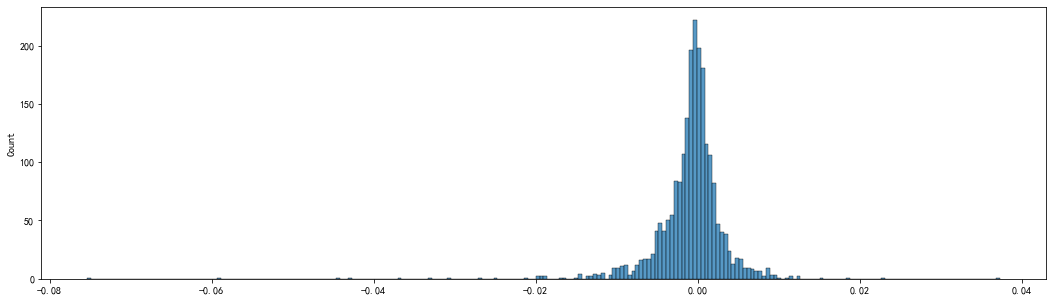

In [78]:
plt.figure(figsize=(18,5))
sns.histplot(is_netbuy_s);

感觉并没有那么强的V型特征

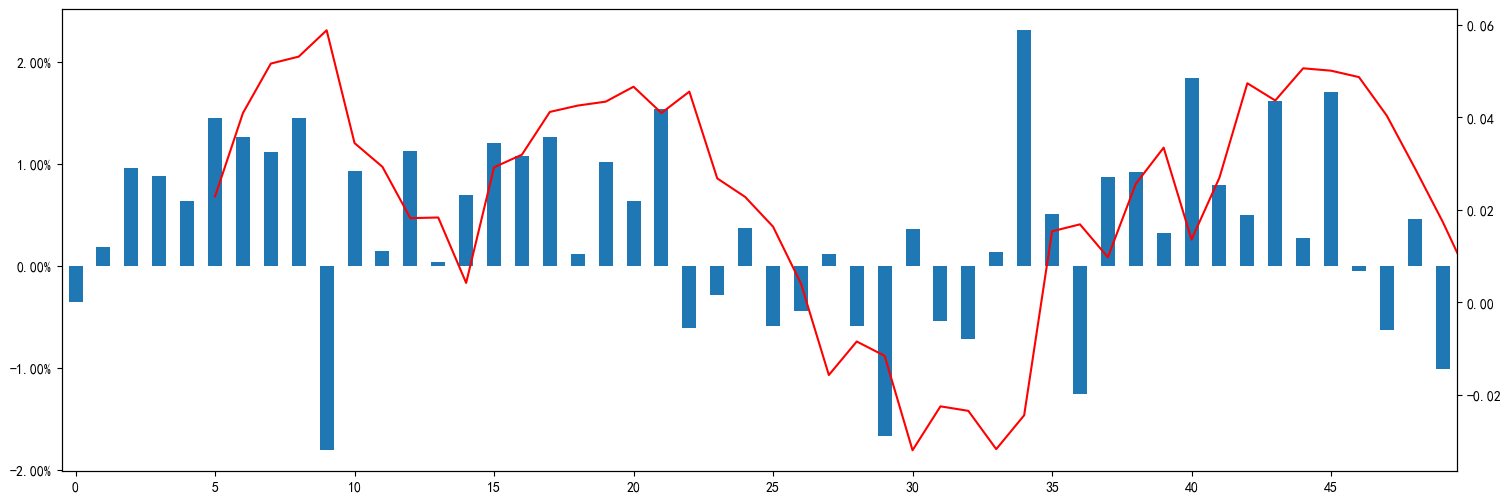

In [184]:
forward_returns: pd.Series = hs300['close'].pct_change(10).shift(-10)
# 根据特征分值分组
group = pd.qcut(is_netbuy_s,50,labels=False) + 1
group_ret = forward_returns.groupby(group).mean()

# 画图
ax = group_ret.plot(kind='bar',figsize=(18,6))
group_ret.rolling(5).sum().plot(kind='line',color='red',secondary_y=True)
ax.yaxis.set_major_formatter('{x:.2%}')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}');

# 信号构建

In [159]:
# 计算HMA信号
is_netbuy_s_s:pd.Series = HMA(is_netbuy_s,30).dropna()
is_netbuy_s_l:pd.Series = HMA(is_netbuy_s,100).dropna()

In [160]:
# 数据对齐
netbuy_s_s,netbuy_s_l = is_netbuy_s_l.align(is_netbuy_s_s,join='left',axis=0)

In [82]:
indincator:pd.DataFrame = pd.concat((netbuy_s_s,netbuy_s_l),axis=1)
indincator.columns = ['fast','slow']

GridSpec(3, 1)

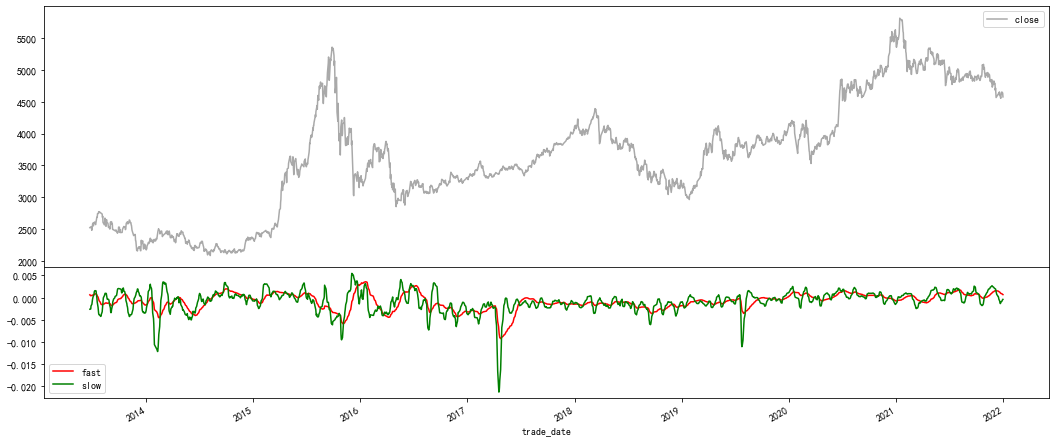

In [83]:
plot_indicator(hs300['close'],indincator)

# Use VBT

In [4]:
import vectorbt as vbt

In [9]:
all_data = pd.concat((hs300, is_netbuy_s), axis=1)
all_data.rename(columns={0: 'netbuy'}, inplace=True)
all_data.head()

,code,close,open,high,low,pre_close,change,pct_chg,vol,amount,netbuy
trade_date,,,,,,,,,,,
2013-01-04,000300.SH,2524.409,2551.814,2558.529,2498.892,2522.952,1.457,0.0577,97988182.0,9.557925e+07,-0.005561
2013-01-07,000300.SH,2535.985,2518.047,2545.969,2511.603,2524.409,11.576,0.4586,75167993.0,7.316751e+07,-0.001727
2013-01-08,000300.SH,2525.330,2534.647,2540.513,2502.490,2535.985,-10.655,-0.4202,71837100.0,7.649806e+07,0.000382
2013-01-09,000300.SH,2526.126,2518.104,2534.239,2504.299,2525.330,0.796,0.0315,70231170.0,7.423360e+07,-0.002068
2013-01-10,000300.SH,2530.569,2525.590,2553.352,2513.729,2526.126,4.443,0.1759,71085862.0,7.115905e+07,0.004894


In [17]:
data = vbt.Data.from_data(data={'hs300':all_data},single_symbol=True,download_kwargs=False)

In [24]:
data

# 回测

## 双均线策略

In [89]:
import datetime as dt

import backtrader as bt
from scr.bt_func import analysis_rets, analysis_trade, get_backtesting

In [161]:
class ma_cross(bt.Strategy):
    """策略逻辑:

    1.大幅相对净流入:IS_NetBuy_S_S>IS_NetBuy_S_L(短期均线大于长期均线)且短期均 线 IS_NetBuy_S_S>0 且长期均线 IS_NetBuy_S_L>0 做多
    2.大幅相对净流出:IS_NetBuy_S_S<IS_NetBuy_S_L(短期均线小于长期均线) 且短期 均线 IS_NetBuy_S_S<0 且长期均线 IS_NetBuy_S_L<0 做多
    """

    def log(self, txt: str, current_dt: dt.datetime = None) -> None:

        current_dt = current_dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (current_dt.isoformat(), txt))

    def __init__(self) -> None:

        self.order = None

    def next(self):
        # 取消之前未执行的订单
        if self.order:
            self.cancel(self.order)

        # 大幅相对净流入
        to_buy1 = (self.datas[0].fast[0] > self.datas[0].slow[0]) and (
            self.datas[0].fast[0] > 0) and (self.datas[0].slow[0] > 0)

        # 大幅相对净流出
        to_buy2 = (self.datas[0].fast[0] < self.datas[0].slow[0]) and (
            self.datas[0].fast[0] < 0) and (self.datas[0].slow[0] < 0)

        # 当 IS_NetBuy_S_S>IS_NetBuy_S_L 且 IS_NetBuy_S_S>0 且 IS_NetBuy_S_L<0

        to_sell1 = (self.datas[0].fast[0] > self.datas[0].slow[0]) and (
            self.datas[0].fast[0] > 0) and (self.datas[0].slow[0] < 0)

        # IS_NetBuy_S_S<IS_NetBuy_S_L 且 IS_NetBuy_S_S<0 且 IS_NetBuy_S_L>0
        to_sell2 = (self.datas[0].fast[0] < self.datas[0].slow[0]) and (
            self.datas[0].fast[0] < 0) and (self.datas[0].slow[0] > 0)

        # 检查是否有持仓
        if not self.position:

            if to_buy1 or to_buy2:
                # 全仓买入
                self.order = self.order_target_percent(target=0.9)

        # 有持仓但不满足规则
        elif (to_sell1) or (to_sell2):
            # 平仓
            self.order = self.close()

    def notify_order(self, order) -> None:

        # 未被处理得订单
        if order.status in [order.Submitted, order.Accepted]:

            return

        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                # buy
                self.log(
                    'BUY EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

            else:
                # sell
                self.log(
                    'SELL EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

In [162]:
# class ma_cross(bt.Strategy):
#     """策略逻辑:

#     简单的双均线逻辑
#     """
#     def log(self, txt: str, current_dt: dt.datetime = None) -> None:

#         current_dt = current_dt or self.datas[0].datetime.date(0)
#         print('%s,%s' % (current_dt.isoformat(), txt))

#     def __init__(self) -> None:

#         self.order = None
#         self.to_buy = bt.indicators.CrossOver(self.data0.lines.fast,self.data0.lines.slow)
#         self.to_sell = bt.indicators.CrossOver(self.data0.lines.slow,self.data0.lines.fast)
        
#     def next(self):
#         # 取消之前未执行的订单
#         if self.order:
#             self.cancel(self.order)

#         # 检查是否有持仓
#         if not self.position:
#             # vix下穿下轨,买入
#             if self.to_buy > 0:
#                 # 全仓买入
#                 self.order = self.order_target_percent(target=0.9)
#         # vix上穿上轨,卖出
#         elif self.to_sell < 0:
#             # 平仓
#             self.order = self.close()


#     def notify_order(self, order) -> None:

#         # 未被处理得订单
#         if order.status in [order.Submitted, order.Accepted]:

#             return

#         if order.status in [order.Completed, order.Canceled, order.Margin]:
#             if order.isbuy():
#                 # buy
#                 self.log(
#                     'BUY EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
#                     % (order.ref, order.executed.price, order.executed.size,
#                        order.executed.value, order.executed.comm,
#                        order.data._name))

#             else:
#                 # sell
#                 self.log(
#                     'SELL EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
#                     % (order.ref, order.executed.price, order.executed.size,
#                        order.executed.value, order.executed.comm,
#                        order.data._name))

In [163]:
bt_data:pd.DataFrame = hs300[['close','open','high','low','vol']].copy()
bt_data.rename(columns={'vol':'volume'},inplace=True)
bt_data['openinterest'] = 0
bt_data = pd.concat((bt_data,indincator),axis=1).dropna()

In [164]:
bt_result = get_backtesting(bt_data,'hs300',ma_cross)

2013-07-08,BUY EXECUTED,ref:1044,Price:2194.6424,Size:40.00,Cost:87785.6977,Comm 0.0000,Stock:hs300
2013-07-19,SELL EXECUTED,ref:1045,Price:2247.9082,Size:-40.00,Cost:87785.6977,Comm 0.0000,Stock:hs300
2013-08-08,BUY EXECUTED,ref:1046,Price:2277.4807,Size:40.00,Cost:91099.2290,Comm 0.0000,Stock:hs300
2013-08-13,SELL EXECUTED,ref:1047,Price:2352.6477,Size:-40.00,Cost:91099.2290,Comm 0.0000,Stock:hs300
2013-08-22,BUY EXECUTED,ref:1048,Price:2302.8983,Size:40.00,Cost:92115.9307,Comm 0.0000,Stock:hs300
2013-09-23,SELL EXECUTED,ref:1049,Price:2441.2718,Size:-40.00,Cost:92115.9307,Comm 0.0000,Stock:hs300
2013-10-24,BUY EXECUTED,ref:1050,Price:2412.4762,Size:41.00,Cost:98911.5252,Comm 0.0000,Stock:hs300
2013-10-28,SELL EXECUTED,ref:1051,Price:2372.3337,Size:-41.00,Cost:98911.5252,Comm 0.0000,Stock:hs300
2013-11-21,BUY EXECUTED,ref:1052,Price:2412.6922,Size:40.00,Cost:96507.6898,Comm 0.0000,Stock:hs300
2013-11-26,SELL EXECUTED,ref:1053,Price:2387.5872,Size:-40.00,Cost:96507.6898,Comm 0.0000,St

,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,7.79%,85.80%,15.47%,56.29%,-27.84%,79.71%,28.00%
基准,10.47%,127.54%,22.86%,55.10%,-46.70%,75.95%,22.43%


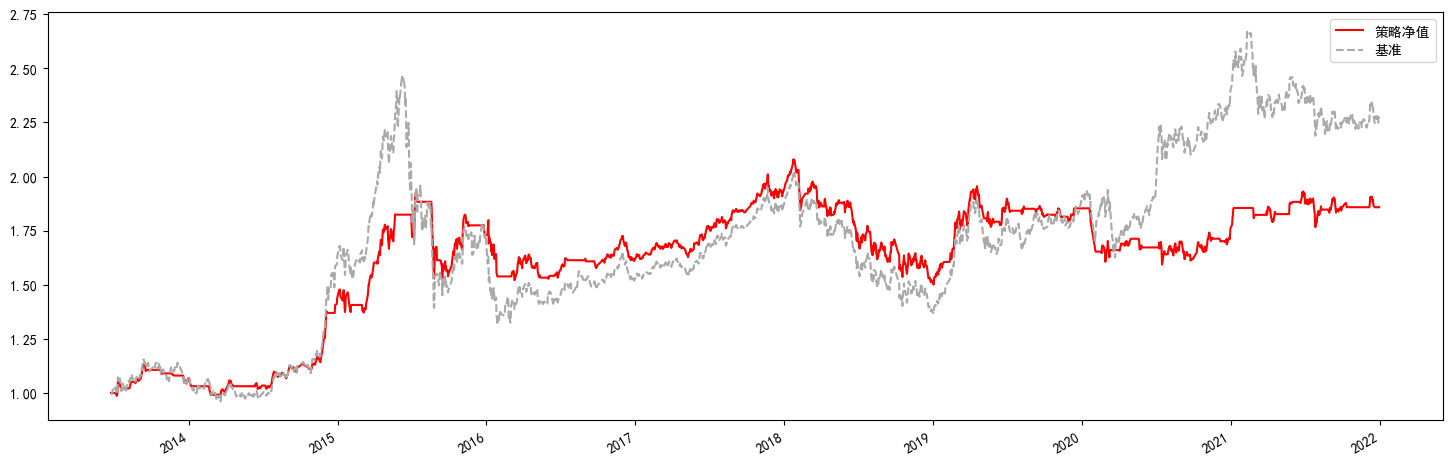

In [165]:
analysis_rets(bt_data['close'],bt_result.result)

,总交易次数,持仓最长时间(自然天),持仓最短时间(自然天),平均持仓天数(自然天),胜率(%),盈亏比
交易指标,56,517,1,35.803571,53.57%,1.6


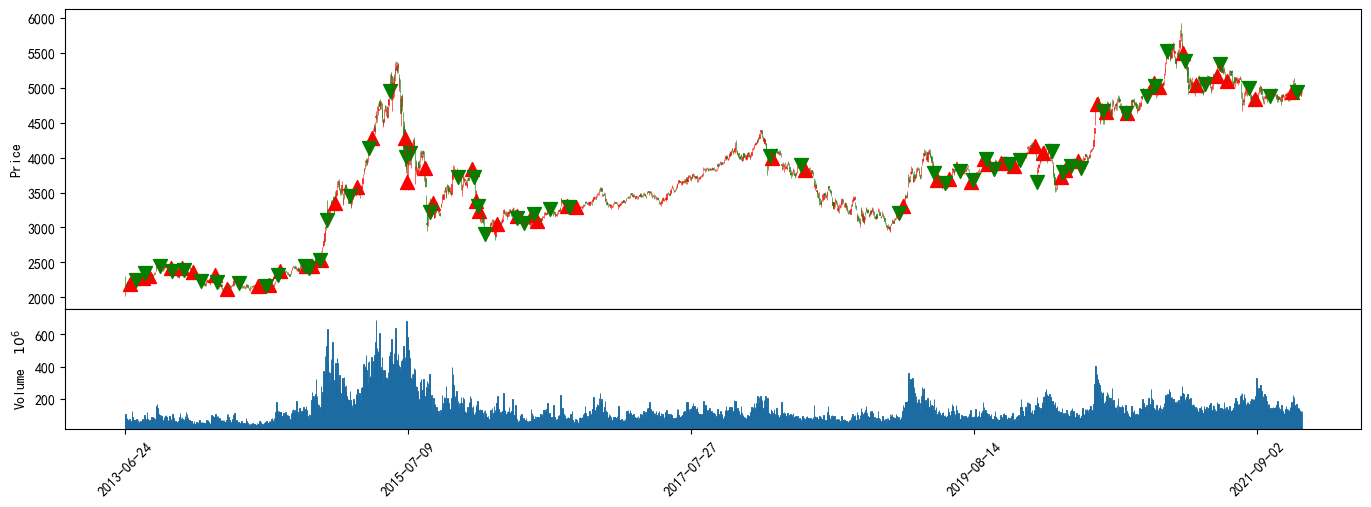

In [166]:
analysis_trade(bt_data,bt_result.result)

## 百分位

In [170]:
class add_quantile_data(bt.feeds.PandasData):
    
    """用于加载回测用数据

    添加信号数据
    """
    lines = (
        'ub',
        'signal',
        'lb',
    )

    params = (('ub', -1), ('signal', -1), ('lb', -1))


class quantile_bound_strategy(bt.Strategy):
    """百分位上下轨策略

    当下穿下轨时开仓,上穿上轨时平仓
    signal,ub,lb提前加载到数据中
    """

    def log(self, txt: str, current_dt: dt.datetime = None) -> None:

        current_dt = current_dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (current_dt.isoformat(), txt))

    def __init__(self) -> None:
        # print('signal', self.data0.lines.signal)
        # 开仓信号
        # if上穿则1,否则为-1
        self.open_signal = bt.indicators.CrossOver(self.data0.lines.lb,
                                                   self.data0.lines.signal)
        # 平仓信号
        self.close_signal = bt.indicators.CrossOver(self.data0.lines.signal,
                                                    self.data0.lines.ub)

        self.order = None

    def next(self):
        # 取消之前未执行的订单
        if self.order:
            self.cancel(self.order)

        # 检查是否有持仓
        if not self.position:
            # vix下穿下轨,买入
            if self.open_signal > 0:
                # 全仓买入
                self.order = self.order_target_percent(target=0.9)
        # vix上穿上轨,卖出
        elif self.close_signal < 0:
            # 平仓
            self.order = self.close()

    def notify_order(self, order) -> None:

        # 未被处理得订单
        if order.status in [order.Submitted, order.Accepted]:

            return

        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                # buy
                self.log(
                    'BUY EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

            else:
                # sell
                self.log(
                    'SELL EXECUTED,ref:%.0f,Price:%.4f,Size:%.2f,Cost:%.4f,Comm %.4f,Stock:%s'
                    % (order.ref, order.executed.price, order.executed.size,
                       order.executed.value, order.executed.comm,
                       order.data._name))

In [171]:
bt_data1:pd.DataFrame = hs300[['close','open','high','low','vol']].copy()
bt_data1.rename(columns={'vol':'volume'},inplace=True)
bt_data1['openinterest'] = 0
bt_data1 = pd.concat((bt_data1,quantile_indincator),axis=1).dropna()

In [172]:
bt_result = get_backtesting(bt_data1,'hs300',quantile_bound_strategy,add_quantile_data)

2013-04-16,BUY EXECUTED,ref:1156,Price:2419.7500,Size:36.00,Cost:87110.9982,Comm 0.0000,Stock:hs300
2013-04-19,SELL EXECUTED,ref:1157,Price:2469.7040,Size:-36.00,Cost:87110.9982,Comm 0.0000,Stock:hs300
2013-04-23,BUY EXECUTED,ref:1158,Price:2532.2010,Size:36.00,Cost:91159.2360,Comm 0.0000,Stock:hs300
2013-04-26,SELL EXECUTED,ref:1159,Price:2477.4762,Size:-36.00,Cost:91159.2360,Comm 0.0000,Stock:hs300
2013-05-14,BUY EXECUTED,ref:1160,Price:2526.1450,Size:35.00,Cost:88415.0750,Comm 0.0000,Stock:hs300
2013-05-21,SELL EXECUTED,ref:1161,Price:2607.1323,Size:-35.00,Cost:88415.0750,Comm 0.0000,Stock:hs300
2013-07-11,BUY EXECUTED,ref:1162,Price:2232.3802,Size:41.00,Cost:91527.5888,Comm 0.0000,Stock:hs300
2013-08-08,SELL EXECUTED,ref:1163,Price:2277.0253,Size:-41.00,Cost:91527.5888,Comm 0.0000,Stock:hs300
2013-08-21,BUY EXECUTED,ref:1164,Price:2320.8161,Size:40.00,Cost:92832.6423,Comm 0.0000,Stock:hs300
2013-09-06,SELL EXECUTED,ref:1165,Price:2336.5333,Size:-40.00,Cost:92832.6423,Comm 0.0000,St

,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,3.58%,34.60%,14.95%,31.03%,-31.46%,43.32%,11.38%
基准,8.54%,99.83%,22.91%,47.32%,-46.70%,64.86%,18.29%


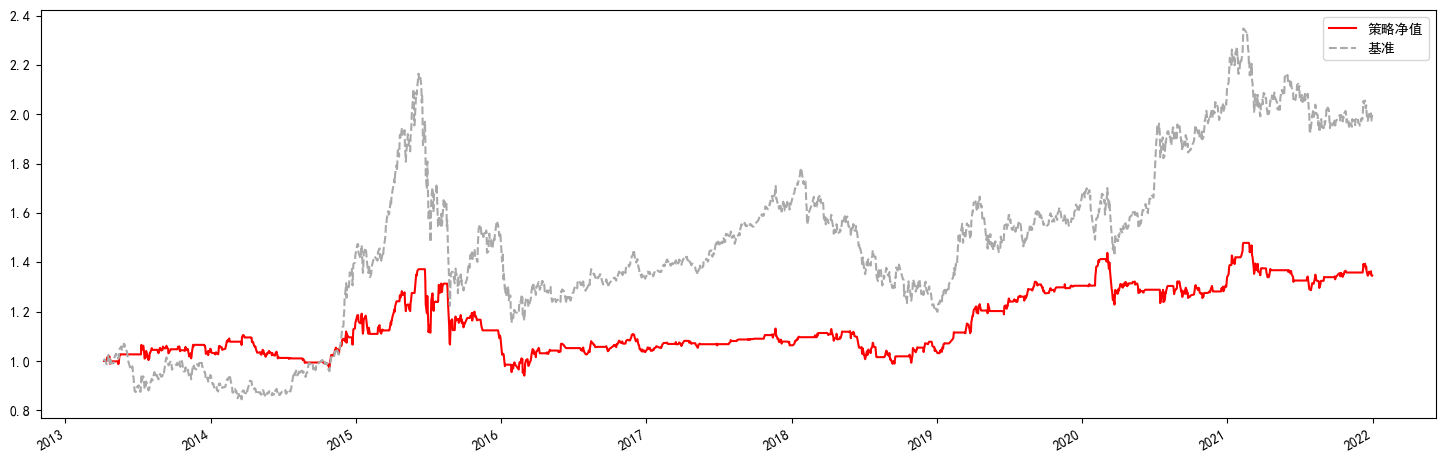

In [173]:
analysis_rets(bt_data1['close'],bt_result.result)